# 3. XGBClassifier
**Start from the most basic features, and try to improve step by step.**

Kaggle score: 0.7028

Abstract: 使用XGBClassifier_GridSearchCV搜索出来的参数（TalkingdataAFD2018_XGBClassifier_GridSearchCV_20180427_152307_9825），然而，跑出来的val的结果和test提交结果都相差很多。猜想是因为这边没有KFold做CV，所以结果变差。后面将主要使用XGBClassifier_GridSearchCV来调参。

Name | acc_train | roc_train | acc_val | roc_val | kaggle score
----:|:---------:|:---------:|:-------:|:-------:|:------------
XGBClassifier          | 0.9974 | 0.8521 | 0.9974 | 0.8523 | 0.7028
XGBClassifier_GridSearchCV | 0.9977 | 0.9882 | 0.0023 | 0.9826 | 0.9666

Reference:
- XGBoost Parameters, http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
- Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html
- sklearn.model_selection.GridSearchCV, http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## Run name

In [1]:
import time

project_name = 'TalkingdataAFD2018'
step_name = 'XGBClassifier'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = '%s_%s_%s' % (project_name, step_name, time_str)
print('run_name: %s' % run_name)
t0 = time.time()

run_name: TalkingdataAFD2018_XGBClassifier_20180427_161239


## Important params

In [2]:
date = 6
print('date: ', date)

test_n_rows = None
# test_n_rows = 18790469
# test_n_rows = 10*10000

date:  6


In [3]:
day_rows = {
    0: {
        'n_skiprows': 1,
        'n_rows': 10 * 10000
    },
    6: {
        'n_skiprows': 1,
        'n_rows': 9308568
    },
    7: {
        'n_skiprows': 1 + 9308568,
        'n_rows': 59633310
    },
    8: {
        'n_skiprows': 1 + 9308568 + 59633310,
        'n_rows': 62945075
    },
    9: {
        'n_skiprows': 1 + 9308568 + 59633310 + 62945075,
        'n_rows': 53016937
    }
}
n_skiprows = day_rows[date]['n_skiprows']
n_rows = day_rows[date]['n_rows']

## Import PKGs

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import os
import sys
import gc
import time
import random
import zipfile
import h5py
import pickle
import math
from PIL import Image
import shutil

from tqdm import tqdm
import multiprocessing
from multiprocessing import cpu_count

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

random_num = np.random.randint(10000)
print('random_num: %s' % random_num)

random_num: 1927


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Project folders

In [5]:
cwd = os.getcwd()

input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
log_folder = os.path.join(cwd, 'log')
print('input_folder: \t\t\t%s' % input_folder)
print('output_folder: \t\t\t%s' % output_folder)
print('model_folder: \t\t\t%s' % model_folder)
print('log_folder: \t\t\t%s' % log_folder)

train_csv_file = os.path.join(input_folder, 'train.csv')
train_sample_csv_file = os.path.join(input_folder, 'train_sample.csv')
test_csv_file = os.path.join(input_folder, 'test.csv')
sample_submission_csv_file = os.path.join(input_folder, 'sample_submission.csv')

print('\ntrain_csv_file: \t\t%s' % train_csv_file)
print('train_sample_csv_file: \t\t%s' % train_sample_csv_file)
print('test_csv_file: \t\t\t%s' % test_csv_file)
print('sample_submission_csv_file: \t%s' % sample_submission_csv_file)

input_folder: 			D:\Kaggle\talkingdata-adtracking-fraud-detection\input
output_folder: 			D:\Kaggle\talkingdata-adtracking-fraud-detection\output
model_folder: 			D:\Kaggle\talkingdata-adtracking-fraud-detection\model
log_folder: 			D:\Kaggle\talkingdata-adtracking-fraud-detection\log

train_csv_file: 		D:\Kaggle\talkingdata-adtracking-fraud-detection\input\train.csv
train_sample_csv_file: 		D:\Kaggle\talkingdata-adtracking-fraud-detection\input\train_sample.csv
test_csv_file: 			D:\Kaggle\talkingdata-adtracking-fraud-detection\input\test.csv
sample_submission_csv_file: 	D:\Kaggle\talkingdata-adtracking-fraud-detection\input\sample_submission.csv


## Load data

In [6]:
%%time

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'device'        : 'uint16',
    'os'            : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8',
    'click_id'      : 'uint32'
}

train_csv = pd.read_csv(
    train_csv_file, 
    skiprows=range(1, n_skiprows), 
    nrows=n_rows, 
    usecols=train_columns,
    dtype=dtypes,
    parse_dates=['click_time']
)
test_csv = pd.read_csv(
    test_csv_file, 
    nrows=test_n_rows, 
    usecols=test_columns,
    dtype=dtypes,
    parse_dates=['click_time']
)
sample_submission_csv = pd.read_csv(sample_submission_csv_file)

print('train_csv.shape: \t\t', train_csv.shape)
print('test_csv.shape: \t\t', test_csv.shape)
print('sample_submission_csv.shape: \t', sample_submission_csv.shape)
print('train_csv.dtypes: \n', train_csv.dtypes)

display(train_csv.head(2))
display(test_csv.head(2))
display(sample_submission_csv.head(2))

print('train_csv: %.2f Mb' % (sys.getsizeof(train_csv)/1024./1024.))
print('test_csv:  %.2f Mb' % (sys.getsizeof(test_csv)/1024./1024.))

train_csv.shape: 		 (9308568, 7)
test_csv.shape: 		 (18790469, 7)
sample_submission_csv.shape: 	 (18790469, 2)
train_csv.dtypes: 
 ip                       uint32
app                      uint16
device                   uint16
os                       uint16
channel                  uint16
click_time       datetime64[ns]
is_attributed             uint8
dtype: object


,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00


,click_id,is_attributed
0,0,0
1,1,0


train_csv: 186.42 Mb
test_csv:  430.08 Mb
Wall time: 23.5 s


In [7]:
y_data = train_csv['is_attributed']
train_csv.drop(['is_attributed'], axis=1, inplace=True)
display(y_data.head())

click_ids = test_csv['click_id']
test_csv.drop(['click_id'], axis=1, inplace=True)
display(click_ids.head())


display(train_csv.head())
display(test_csv.head())

0    0
1    0
2    0
3    0
4    0
Name: is_attributed, dtype: uint8

0    0
1    1
2    2
3    3
4    4
Name: click_id, dtype: uint32

,ip,app,device,os,channel,click_time
0,83230,3,1,13,379,2017-11-06 14:32:21
1,17357,3,1,19,379,2017-11-06 14:33:34
2,35810,3,1,13,379,2017-11-06 14:34:12
3,45745,14,1,13,478,2017-11-06 14:34:52
4,161007,3,1,13,379,2017-11-06 14:35:08


,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00
1,119901,9,1,3,466,2017-11-10 04:00:00
2,72287,21,1,19,128,2017-11-10 04:00:00
3,78477,15,1,13,111,2017-11-10 04:00:00
4,123080,12,1,13,328,2017-11-10 04:00:00


## Features

In [8]:
train_csv['day'] = train_csv['click_time'].dt.day.astype('uint8')
train_csv['hour'] = train_csv['click_time'].dt.hour.astype('uint8')
train_csv['minute'] = train_csv['click_time'].dt.minute.astype('uint8')
train_csv['second'] = train_csv['click_time'].dt.second.astype('uint8')
print('train_csv.shape: \t', train_csv.shape)
display(train_csv.head(2))

train_csv.shape: 	 (9308568, 10)


,ip,app,device,os,channel,click_time,day,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,6,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,6,14,33,34


In [9]:
test_csv['day'] = test_csv['click_time'].dt.day.astype('uint8')
test_csv['hour'] = test_csv['click_time'].dt.hour.astype('uint8')
test_csv['minute'] = test_csv['click_time'].dt.minute.astype('uint8')
test_csv['second'] = test_csv['click_time'].dt.second.astype('uint8')
print('test_csv.shape: \t', test_csv.shape)
display(test_csv.head(2))

test_csv.shape: 	 (18790469, 10)


,ip,app,device,os,channel,click_time,day,hour,minute,second
0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,0
1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,0


In [10]:
arr = np.array([[3,6,6],[4,5,1]])
print(arr)
np.ravel_multi_index(arr, (7,6))
print(arr)
print(np.ravel_multi_index(arr, (7,6), order='F'))

[[3 6 6]
 [4 5 1]]
[[3 6 6]
 [4 5 1]]
[31 41 13]


In [11]:
def df_add_counts(df, cols, tag="_count"):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(
        np.ravel_multi_index(arr_slice.T, arr_slice.max(0) + 1), 
        return_inverse=True, 
        return_counts=True
    )
    df["_".join(cols) + tag] = counts[unqtags]
    return df

In [12]:
def df_add_uniques(df, cols, tag="_unique"):
    gp = df[cols] \
        .groupby(by=cols[0:len(cols) - 1])[cols[len(cols) - 1]] \
        .nunique() \
        .reset_index() \
        .rename(index=str, columns={cols[len(cols) - 1]: "_".join(cols)+tag})
    df = df.merge(gp, on=cols[0:len(cols) - 1], how='left')
    return df

In [13]:
train_csv = df_add_counts(train_csv, ['ip', 'day', 'hour'])
train_csv = df_add_counts(train_csv, ['ip', 'app'])
train_csv = df_add_counts(train_csv, ['ip', 'app', 'os'])
train_csv = df_add_counts(train_csv, ['ip', 'device'])
train_csv = df_add_counts(train_csv, ['app', 'channel'])
train_csv = df_add_uniques(train_csv, ['ip', 'channel'])
train_csv = df_add_uniques(train_csv, ['ip', 'app', 'device', 'os', 'channel'])
train_csv = df_add_uniques(train_csv, ['ip', 'os', 'device'])
train_csv = df_add_uniques(train_csv, ['ip', 'os', 'device', 'app'])

display(train_csv.head())

,ip,app,device,os,channel,click_time,day,hour,minute,second,ip_day_hour_count,ip_app_count,ip_app_os_count,ip_device_count,app_channel_count,ip_channel_unique,ip_app_device_os_channel_unique,ip_os_device_unique,ip_os_device_app_unique
0,83230,3,1,13,379,2017-11-06 14:32:21,6,14,32,21,1,194,80,1243,48623,82,18,1,24
1,17357,3,1,19,379,2017-11-06 14:33:34,6,14,33,34,1,122,22,922,48623,79,13,1,18
2,35810,3,1,13,379,2017-11-06 14:34:12,6,14,34,12,1,35,5,375,48623,61,4,2,14
3,45745,14,1,13,478,2017-11-06 14:34:52,6,14,34,52,1,459,105,8075,1518,95,12,2,27
4,161007,3,1,13,379,2017-11-06 14:35:08,6,14,35,8,1,26,4,176,48623,53,3,1,12


In [14]:
test_csv = df_add_counts(test_csv, ['ip', 'day', 'hour'])
test_csv = df_add_counts(test_csv, ['ip', 'app'])
test_csv = df_add_counts(test_csv, ['ip', 'app', 'os'])
test_csv = df_add_counts(test_csv, ['ip', 'device'])
test_csv = df_add_counts(test_csv, ['app', 'channel'])
test_csv = df_add_uniques(test_csv, ['ip', 'channel'])
test_csv = df_add_uniques(test_csv, ['ip', 'app', 'device', 'os', 'channel'])
test_csv = df_add_uniques(test_csv, ['ip', 'os', 'device'])
test_csv = df_add_uniques(test_csv, ['ip', 'os', 'device', 'app'])

display(test_csv.head())

,ip,app,device,os,channel,click_time,day,hour,minute,second,ip_day_hour_count,ip_app_count,ip_app_os_count,ip_device_count,app_channel_count,ip_channel_unique,ip_app_device_os_channel_unique,ip_os_device_unique,ip_os_device_app_unique
0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0,0,34,28,1,91,269116,34,1,1,3
1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0,0,403,289,5,2069,372406,90,3,1,14
2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0,0,229,312,24,2092,219966,87,2,1,23
3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0,0,239,42,23,1190,67038,92,10,1,23
4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0,0,60,24,7,203,191986,58,4,1,16


In [15]:
def do_next_prev_Click( df,agg_suffix, agg_type='float32'):
    print('Extracting new features...')
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('int8')
    df['day'] = pd.to_datetime(df.click_time).dt.day.astype('int8')
    
    #### New added
    df['minute'] = pd.to_datetime(df.click_time).dt.minute.astype('int8')
    predictors.append('minute')
    df['second'] = pd.to_datetime(df.click_time).dt.second.astype('int8')
    predictors.append('second')
    print(f">> \nExtracting {agg_suffix} time calculation features...\n")
    
    GROUP_BY_NEXT_CLICKS = [
    
    # V1
    # {'groupby': ['ip']},
    # {'groupby': ['ip', 'app']},
    # {'groupby': ['ip', 'channel']},
    # {'groupby': ['ip', 'os']},
    
    # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
    ]

    # Calculate the time to next click for each group
    for spec in GROUP_BY_NEXT_CLICKS:
    
       # Name of new feature
        new_feature = '{}_{}'.format('_'.join(spec['groupby']),agg_suffix)    
    
        # Unique list of features to select
        all_features = spec['groupby'] + ['click_time']

        # Run calculation
        print(f">> Grouping by {spec['groupby']}, and saving time to {agg_suffix} in: {new_feature}")
        if agg_suffix=="nextClick":
            df[new_feature] = (df[all_features].groupby(spec[
            'groupby']).click_time.shift(-1) - df.click_time).dt.seconds.astype(agg_type)
        elif agg_suffix== "prevClick":
            df[new_feature] = (df.click_time - df[all_features].groupby(spec[
                'groupby']).click_time.shift(+1) ).dt.seconds.astype(agg_type)
        predictors.append(new_feature)
        gc.collect()
#         print('predictors',predictors)
    return (df)

In [16]:
## Below a function is written to extract count feature by aggregating different cols
def do_count( df, group_cols, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name='{}count'.format('_'.join(group_cols))  
    if show_agg:
        print( "\nAggregating by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )
    
##  Below a function is written to extract unique count feature from different cols
def do_countuniq( df, group_cols, counted, agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_countuniq'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCounting unqiue ", counted, " by ", group_cols ,  '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )
### Below a function is written to extract cumulative count feature  from different cols    
def do_cumcount( df, group_cols, counted,agg_type='uint32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_cumcount'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCumulative count by ", group_cols , '... and saved in', agg_name  )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )
### Below a function is written to extract mean feature  from different cols
def do_mean( df, group_cols, counted, agg_type='float32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_mean'.format(('_'.join(group_cols)),(counted))  
    if show_agg:
        print( "\nCalculating mean of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_type='float32', show_max=False, show_agg=True ):
    agg_name= '{}_by_{}_var'.format(('_'.join(group_cols)),(counted)) 
    if show_agg:
        print( "\nCalculating variance of ", counted, " by ", group_cols , '... and saved in', agg_name )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    predictors.append(agg_name)
#     print('predictors',predictors)
    gc.collect()
    return( df )

In [17]:
len_train = len(train_csv)
train_df=train_csv.append(test_csv)
predictors=[]

In [18]:
gc.collect()
train_df = do_next_prev_Click( train_df,agg_suffix='nextClick', agg_type='float32'  ); gc.collect()
# train_df = do_next_prev_Click( train_df,agg_suffix='prevClick', agg_type='float32'  ); gc.collect()  ## Removed temporarily due RAM sortage. 
train_df = do_countuniq( train_df, ['ip'], 'channel' ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app'); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'day'], 'hour' ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app'); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'app'], 'os'); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'device'); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel'); gc.collect()
train_df = do_cumcount( train_df, ['ip'], 'os'); gc.collect()
train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app'); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'] ); gc.collect()
train_df = do_count( train_df, ['ip', 'app']); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os']); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour'); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour'); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day'); gc.collect()
train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour' ); gc.collect()

print(train_df.head(5))
gc.collect()

Extracting new features...
>> 
Extracting nextClick time calculation features...

>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to nextClick in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to nextClick in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to nextClick in: ip_os_device_app_nextClick

Counting unqiue  channel  by  ['ip'] ... and saved in ip_by_channel_countuniq

Counting unqiue  app  by  ['ip', 'device', 'os'] ... and saved in ip_device_os_by_app_countuniq

Counting unqiue  hour  by  ['ip', 'day'] ... and saved in ip_day_by_hour_countuniq

Counting unqiue  app  by  ['ip'] ... and saved in ip_by_app_countuniq

Counting unqiue  os  by  ['ip', 'app'] ... and saved in ip_app_by_os_countuniq

Counting unqiue  device  by  ['ip'] ... and saved in ip_by_device_countuniq

Counting unqiue  channel  by  ['app'] ... and saved in app_by_channel_countuniq

Cumulative count by  [

52

In [19]:
train_csv = train_df[:len_train]
test_csv = train_df[len_train:]

del train_df; gc.collect()

print(train_csv.shape)
print(test_csv.shape)

(9308568, 38)
(18790469, 38)


## Prepare data

In [20]:
print(train_csv.columns)
print(test_csv.columns)

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'day', 'hour',
       'minute', 'second', 'ip_day_hour_count', 'ip_app_count',
       'ip_app_os_count', 'ip_device_count', 'app_channel_count',
       'ip_channel_unique', 'ip_app_device_os_channel_unique',
       'ip_os_device_unique', 'ip_os_device_app_unique',
       'ip_app_device_os_channel_nextClick', 'ip_os_device_nextClick',
       'ip_os_device_app_nextClick', 'ip_by_channel_countuniq',
       'ip_device_os_by_app_countuniq', 'ip_day_by_hour_countuniq',
       'ip_by_app_countuniq', 'ip_app_by_os_countuniq',
       'ip_by_device_countuniq', 'app_by_channel_countuniq',
       'ip_by_os_cumcount', 'ip_device_os_by_app_cumcount', 'ip_day_hourcount',
       'ip_appcount', 'ip_app_oscount', 'ip_day_channel_by_hour_var',
       'ip_app_os_by_hour_var', 'ip_app_channel_by_day_var',
       'ip_app_channel_by_hour_mean'],
      dtype='object')
Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'day', 'hour',
      

In [21]:
train_useless_features = ['click_time']
train_csv.drop(train_useless_features, axis=1, inplace=True)

test_useless_features = ['click_time']
test_csv.drop(test_useless_features, axis=1, inplace=True)

display(train_csv.head())
display(test_csv.head())

,ip,app,device,os,channel,day,hour,minute,second,ip_day_hour_count,...,app_by_channel_countuniq,ip_by_os_cumcount,ip_device_os_by_app_cumcount,ip_day_hourcount,ip_appcount,ip_app_oscount,ip_day_channel_by_hour_var,ip_app_os_by_hour_var,ip_app_channel_by_day_var,ip_app_channel_by_hour_mean
0,83230,3,1,13,379,6,14,32,21,1,...,40,0,0,1,526,185,7.893333,25.320681,3.698435,11.526316
1,17357,3,1,19,379,6,14,33,34,1,...,40,0,0,1,342,93,9.618462,27.029686,3.766154,12.307693
2,35810,3,1,13,379,6,14,34,12,1,...,40,0,0,1,179,25,15.600000,31.000000,2.285714,12.857142
3,45745,14,1,13,478,6,14,34,52,1,...,36,0,0,1,1532,337,5.947712,30.732372,4.800000,12.500000
4,161007,3,1,13,379,6,14,35,8,1,...,40,0,0,1,26,4,10.800000,20.250000,0.000000,17.750000


,ip,app,device,os,channel,day,hour,minute,second,ip_day_hour_count,...,app_by_channel_countuniq,ip_by_os_cumcount,ip_device_os_by_app_cumcount,ip_day_hourcount,ip_appcount,ip_app_oscount,ip_day_channel_by_hour_var,ip_app_os_by_hour_var,ip_app_channel_by_day_var,ip_app_channel_by_hour_mean
9308568,5744,9,1,3,107,10,4,0,0,34,...,45,19,0,34,28,1,0.333333,NaN,0.000000,4.500000
9308569,119901,9,1,3,466,10,4,0,0,403,...,45,1101,109,403,397,5,13.130157,4.700000,0.840841,8.891891
9308570,72287,21,1,19,128,10,4,0,0,229,...,7,611,117,229,329,27,10.612795,26.310541,3.663673,12.080000
9308571,78477,15,1,13,111,10,4,0,0,239,...,28,427,154,239,78,39,0.000000,63.392712,0.000000,4.000000
9308572,123080,12,1,13,328,10,4,0,0,60,...,30,124,4,60,44,8,0.000000,22.000000,0.000000,4.000000


In [22]:
x_train, x_val, y_train, y_val = train_test_split(train_csv, y_data, test_size=0.05, random_state=2017)
x_test = test_csv
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

print('Time cost: %.2f s' % (time.time() - t0))

(8843139, 37)
(8843139,)
(465429, 37)
(465429,)
(18790469, 37)
Time cost: 818.96 s


In [23]:
print(x_train.columns)
print(x_val.columns)
print(x_test.columns)

Index(['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute',
       'second', 'ip_day_hour_count', 'ip_app_count', 'ip_app_os_count',
       'ip_device_count', 'app_channel_count', 'ip_channel_unique',
       'ip_app_device_os_channel_unique', 'ip_os_device_unique',
       'ip_os_device_app_unique', 'ip_app_device_os_channel_nextClick',
       'ip_os_device_nextClick', 'ip_os_device_app_nextClick',
       'ip_by_channel_countuniq', 'ip_device_os_by_app_countuniq',
       'ip_day_by_hour_countuniq', 'ip_by_app_countuniq',
       'ip_app_by_os_countuniq', 'ip_by_device_countuniq',
       'app_by_channel_countuniq', 'ip_by_os_cumcount',
       'ip_device_os_by_app_cumcount', 'ip_day_hourcount', 'ip_appcount',
       'ip_app_oscount', 'ip_day_channel_by_hour_var', 'ip_app_os_by_hour_var',
       'ip_app_channel_by_day_var', 'ip_app_channel_by_hour_mean'],
      dtype='object')
Index(['ip', 'app', 'device', 'os', 'channel', 'day', 'hour', 'minute',
       'second', 'ip_day_hour_c

In [24]:
print(type(x_train))
print(type(y_train))
print(type(x_val))
print(type(y_val))
print(type(x_test))

x_train = x_train.as_matrix()
y_train = y_train.as_matrix()
x_val = x_val.as_matrix()
y_val = y_val.as_matrix()
x_test = x_test.as_matrix()

print(type(x_train))
print(type(y_train))
print(type(x_val))
print(type(y_val))
print(type(x_test))

gc.collect()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0

## Train

In [25]:
# %%time
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import roc_auc_score


clf = xgb.XGBClassifier(
    max_depth=3, 
    learning_rate=0.1, 
    n_estimators=1000, 
    silent=False, 
    objective='gpu:binary:logistic', 
    booster='gbtree', 
#     n_jobs=1, 
    nthread=None, 
    gamma=0, 
    min_child_weight=1, 
    max_delta_step=0, 
    subsample=0.5, 
    colsample_bytree=0.7, 
    colsample_bylevel=0.7, 
    reg_alpha=0.3, 
    reg_lambda=0.8, 
    scale_pos_weight=10, 
    base_score=0.5, 
    random_state=0, 
    seed=None, 
    missing=None,
    # booster params
    num_boost_round=50,
    early_stopping_rounds=30,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric=['auc'],

)

clf.fit(
    x_train, 
    y_train,
#     sample_weight=None, 
    eval_set=[(x_train, y_train), (x_val, y_val)], 
#     eval_metric=['auc', 'logloss', 'error'], 
    eval_metric=['auc'], 
#     valid_names=['train','valid'],
#     num_boost_round=50,
    early_stopping_rounds=20, 
#     verbose=False, 
#     xgb_model=None
)


[0]	validation_0-auc:0.851597	validation_1-auc:0.848047
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.881665	validation_1-auc:0.882392
[2]	validation_0-auc:0.904097	validation_1-auc:0.90889
[3]	validation_0-auc:0.907111	validation_1-auc:0.912588
[4]	validation_0-auc:0.917579	validation_1-auc:0.922352
[5]	validation_0-auc:0.91759	validation_1-auc:0.922312
[6]	validation_0-auc:0.917559	validation_1-auc:0.922001
[7]	validation_0-auc:0.917857	validation_1-auc:0.921996
[8]	validation_0-auc:0.917942	validation_1-auc:0.922153
[9]	validation_0-auc:0.917987	validation_1-auc:0.922185
[10]	validation_0-auc:0.918439	validation_1-auc:0.922559
[11]	validation_0-auc:0.91869	validation_1-auc:0.923132
[12]	validation_0-auc:0.942296	validation_1-auc:0.946402
[13]	validation_0-auc:0.9425	validation_1-auc:0.946815
[14]	validation_0-auc:0.942463	validation_1-auc:0.946804
[15

[142]	validation_0-auc:0.978769	validation_1-auc:0.979528
[143]	validation_0-auc:0.978856	validation_1-auc:0.979612
[144]	validation_0-auc:0.978898	validation_1-auc:0.979619
[145]	validation_0-auc:0.978934	validation_1-auc:0.979658
[146]	validation_0-auc:0.979022	validation_1-auc:0.979704
[147]	validation_0-auc:0.979049	validation_1-auc:0.979759
[148]	validation_0-auc:0.979099	validation_1-auc:0.979839
[149]	validation_0-auc:0.979189	validation_1-auc:0.979921
[150]	validation_0-auc:0.979228	validation_1-auc:0.979886
[151]	validation_0-auc:0.979278	validation_1-auc:0.979883
[152]	validation_0-auc:0.979335	validation_1-auc:0.97994
[153]	validation_0-auc:0.979457	validation_1-auc:0.979957
[154]	validation_0-auc:0.979486	validation_1-auc:0.979926
[155]	validation_0-auc:0.979529	validation_1-auc:0.979907
[156]	validation_0-auc:0.979564	validation_1-auc:0.97995
[157]	validation_0-auc:0.979587	validation_1-auc:0.979995
[158]	validation_0-auc:0.979711	validation_1-auc:0.980015
[159]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, early_stopping_rounds=30, eval_metric=['auc'],
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_boost_round=50, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0.3,
       reg_lambda=0.8, scale_pos_weight=10, seed=None, silent=False,
       subsample=0.5, tree_method='gpu_hist')

In [26]:
y_train_proba = clf.predict(x_train)
y_train_pred = (y_train_proba>=0.5).astype(int)
acc_train = accuracy_score(y_train, y_train_pred)
roc_train = roc_auc_score(y_train, y_train_proba)
print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

y_val_proba = clf.predict(x_val)
y_val_pred = (y_val_proba>=0.5).astype(int)
acc_val = accuracy_score(y_val, y_val_pred)
roc_val = roc_auc_score(y_val, y_val_proba)
print('acc_val:   %.4f \t roc_val:   %.4f' % (acc_val, roc_val))

acc_train: 0.9974 	 roc_train: 0.8521
acc_val:   0.9974 	 roc_val:   0.8523


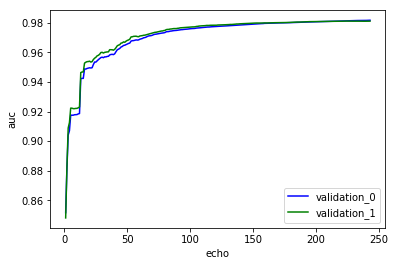

In [27]:
evals_result = clf.evals_result()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

n_round = len(evals_result['validation_0']['auc'])
x = list(range(1, n_round + 1))
for metric_key in evals_result['validation_0'].keys():
    plt.xlabel('echo')
    plt.ylabel(metric_key)
    for i, val_key in enumerate(evals_result.keys()):
        plt.plot(x, evals_result[val_key][metric_key], colors[i])
    plt.legend(labels = list(evals_result.keys()), loc = 'best')
    plt.show()

In [28]:
del x_train; gc.collect()
del x_val; gc.collect()

0

## Predict

In [29]:
run_name_acc = run_name + '_' + str(int(roc_val*10000)).zfill(4)
print(run_name_acc)

TalkingdataAFD2018_XGBClassifier_20180427_161239_8522


In [30]:
from sklearn.cross_validation import KFold

kf = KFold(105, n_folds=10)
for train_index, test_index in kf:
    print(test_index)

[ 0  1  2  3  4  5  6  7  8  9 10]
[11 12 13 14 15 16 17 18 19 20 21]
[22 23 24 25 26 27 28 29 30 31 32]
[33 34 35 36 37 38 39 40 41 42 43]
[44 45 46 47 48 49 50 51 52 53 54]
[55 56 57 58 59 60 61 62 63 64]
[65 66 67 68 69 70 71 72 73 74]
[75 76 77 78 79 80 81 82 83 84]
[85 86 87 88 89 90 91 92 93 94]
[ 95  96  97  98  99 100 101 102 103 104]


In [31]:
kf = KFold(len(x_test), n_folds=10)
y_test_proba = []
for train_index, test_index in kf:
    y_test_proba_fold = clf.predict(x_test[test_index])
    y_test_proba.append(y_test_proba_fold)
    print(y_test_proba_fold.shape)
    
y_test_proba = np.concatenate(y_test_proba, axis=0)

print(y_test_proba.shape)
print(y_test_proba[:20])

(1879047,)
(1879047,)
(1879047,)
(1879047,)
(1879047,)
(1879047,)
(1879047,)
(1879047,)
(1879047,)
(1879046,)
(18790469,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
def save_proba(y_train_proba, y_train, y_val_proba, y_val, y_test_proba, click_ids, file_name):
    print(click_ids[:5])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: \t%s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_train_proba', data=y_train_proba)
        h.create_dataset('y_train', data=y_train)
        h.create_dataset('y_val_proba', data=y_val_proba)
        h.create_dataset('y_val', data=y_val)
        h.create_dataset('y_test_proba', data=y_test_proba)
        h.create_dataset('click_ids', data=click_ids)
    print('File saved: \t%s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_train_proba = np.array(h['y_train_proba'])
        y_train = np.array(h['y_train'])
        y_val_proba = np.array(h['y_val_proba'])
        y_val = np.array(h['y_val'])
        y_test_proba = np.array(h['y_test_proba'])
        click_ids = np.array(h['click_ids'])
    print('File loaded: \t%s' % file_name)
    print(click_ids[:5])
    
    return y_train_proba, y_train, y_val_proba, y_val, y_test_proba, click_ids


y_proba_file = os.path.join(model_folder, 'proba_%s.p' % run_name_acc)
save_proba(y_train_proba, y_train, y_val_proba, y_val, y_test_proba, np.array(sample_submission_csv['click_id']), y_proba_file)
y_train_proba, y_train, y_val_proba, y_val, y_test_proba, click_ids = load_proba(y_proba_file)

print(y_train_proba.shape)
print(y_train.shape)
print(y_val_proba.shape)
print(y_val.shape)
print(y_test_proba.shape)
print(len(click_ids))

[0 1 2 3 4]
File saved: 	D:\Kaggle\talkingdata-adtracking-fraud-detection\model\proba_TalkingdataAFD2018_XGBClassifier_20180427_161239_8522.p
File loaded: 	D:\Kaggle\talkingdata-adtracking-fraud-detection\model\proba_TalkingdataAFD2018_XGBClassifier_20180427_161239_8522.p
[0 1 2 3 4]
(8843139,)
(8843139,)
(465429,)
(465429,)
(18790469,)
18790469


In [33]:
# %%time
submission_csv_file = os.path.join(output_folder, 'pred_%s.csv' % run_name_acc)
print(submission_csv_file)
submission_csv = pd.DataFrame({ 'click_id': click_ids , 'is_attributed': y_test_proba })
submission_csv.to_csv(submission_csv_file, index = False)

D:\Kaggle\talkingdata-adtracking-fraud-detection\output\pred_TalkingdataAFD2018_XGBClassifier_20180427_161239_8522.csv


In [34]:
print('Time cost: %.2f s' % (time.time() - t0))

print('random_num: ', random_num)
print('date: ', date)
print(run_name_acc)
print('Done!')

Time cost: 1109.70 s
random_num:  1927
date:  6
TalkingdataAFD2018_XGBClassifier_20180427_161239_8522
Done!
